# Structured data with fastai

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
from sklearn.metrics import mean_absolute_error, r2_score
import yellowbrick
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
PATH=Path(r'D:\Research\MLDS-master\EnergyAI\Notebooks')

## Dataset

In [3]:
Data = pd.read_csv(PATH/'Energy_Results.csv')

In [4]:
Data['Consumption'] = Data['Cooling'] + Data['Heating'] + Data['Lighting'] + Data['Fans'] + Data['Pumps']

In [5]:
Data.drop(labels=['AverageOpTemp', 'MinOpTemp', 'MaxOpTemp', 'AverageAirTemp', 'MinAirTemp', 'MaxAirTemp', 
                  'AverageMRT', 'MinMRT', 'MaxMRT', 'AverageRH', 'MinRH', 'MaxRH', 'PeakCoolingLoad',
                  'PeakHeatingLoad', 'CoolingSizing', 'HeatingSizing', 'Cooling', 'Heating', 'Lighting',
                  'Fans', 'Pumps'], axis=1, inplace=True)
Data.head(5)

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Consumption
0,1,Core,20,DP,0.2,0.5,11,1,1097.463796
1,1,Core,20,DP,0.2,0.5,11,2,1064.910481
2,1,Core,20,DP,0.2,0.5,16,0,1950.238591
3,1,Core,20,DP,0.2,0.5,16,1,1764.380026
4,1,Core,20,DP,0.2,0.5,16,2,1682.937558


In [6]:
cat_vars = ['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery', 'WWR', 'SHGC', 
            'OverhangLength']

#contin_vars = ['WWR', 'SHGC', 'OverhangLength']

n = len(Data); n

45315

In [7]:
for v in cat_vars: Data[v] = Data[v].astype('category').cat.as_ordered()
#for v in contin_vars: Data[v] = Data[v].fillna(0).astype('float32')

In [8]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            this_xs = this_xs.reindex(np.random.permutation(this_xs.index))

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = pd.concat(xs)
    xr = x.drop(labels=xs.index.values, axis=0)

    return xs,xr

In [9]:
train_data, test_data = balanced_subsample(Data, Data['ClimateZone'], subsample_size=0.2)

print('Length of training dataset is: ', len(train_data))
print('Length of test dataset is:     ', len(test_data))

Length of training dataset is:  9032
Length of test dataset is:      36283


In [10]:
df_train, y, nas = proc_df(train_data, 'Consumption', do_scale=False)
yl = np.log(y)

In [11]:
df_test, _, nas = proc_df(test_data, 'Consumption', do_scale=False, na_dict=nas)
df_check = df_test

## DL

In [12]:
def inv_y(a): return np.exp(a)

def mae(y_pred, targ):
    targ = inv_y(targ)
    y_pred = inv_y(y_pred)
    return np.average(np.abs(y_pred - targ))

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

val_idx=[0]

In [13]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df_train, yl.astype(np.float32), cat_flds=cat_vars, 
                                       bs=128, test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [14]:
cat_sz = [(c, len(train_data[c].cat.categories)+1) for c in cat_vars]

In [15]:
cat_sz

[('ClimateZone', 9),
 ('Orientation', 6),
 ('GlazingType', 3),
 ('HVAC', 4),
 ('HeatRecovery', 4),
 ('WWR', 8),
 ('SHGC', 4),
 ('OverhangLength', 4)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [16]:
emb_szs = [(c, max(50, (c+1)//2)) for _,c in cat_sz]

In [17]:
emb_szs

[(9, 50), (6, 50), (3, 50), (4, 50), (4, 50), (8, 50), (4, 50), (4, 50)]

In [18]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars), 
                   0.1, 1, [500,200], [0.01,0.1], y_range=y_range)
lr = 1e-2

In [19]:
m.lr_find()

epoch      trn_loss   val_loss                                                                                         
    0      4.457324   9.901442  



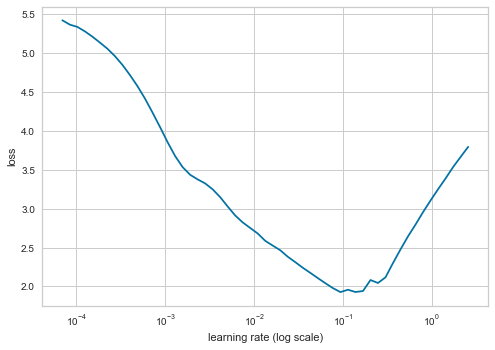

In [20]:
m.sched.plot()

In [21]:
lr = 1e-3

In [113]:
m.fit(lr, 1, metrics=[mae], cycle_len=5, use_clr_beta=(50, 15, 0.95, 0.85))

epoch      trn_loss   val_loss   mae                                                                                   
    0      0.002629   0.00077    33.017578 
    1      0.003077   0.003607   70.314697                                                                             
    2      0.003408   0.001195   40.99292                                                                              
    3      0.00285    0.000931   36.241821                                                                             
    4      0.002608   0.000859   34.83667                                                                              



[array([0.00086]), 34.836669921875]

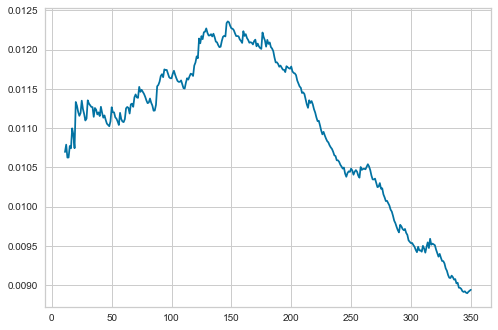

In [39]:
m.sched.plot_loss()

In [212]:
m.fit(lr/32, 1, wds=1e-7, metrics=[mae], cycle_len=15, use_clr_beta=(50, 15, 0.95, 0.85))

epoch      trn_loss   val_loss   mae                                                                                   
    0      0.001056   5.9e-05    9.236694  
    1      0.000984   5.4e-05    8.801025                                                                              
    2      0.000994   4.4e-05    8.00708                                                                               
    3      0.000996   5.5e-05    8.946655                                                                              
    4      0.000985   4.1e-05    7.688843                                                                              
    5      0.00103    4.9e-05    8.400757                                                                              
    6      0.000996   3.7e-05    7.325317                                                                              
    7      0.000954   3.1e-05    6.69104                                                                            

[array([0.00004]), 7.5699462890625]

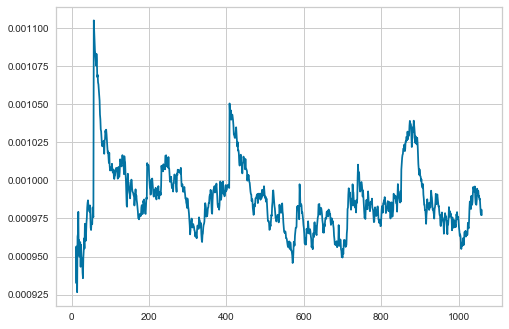

In [213]:
m.sched.plot_loss()

In [214]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

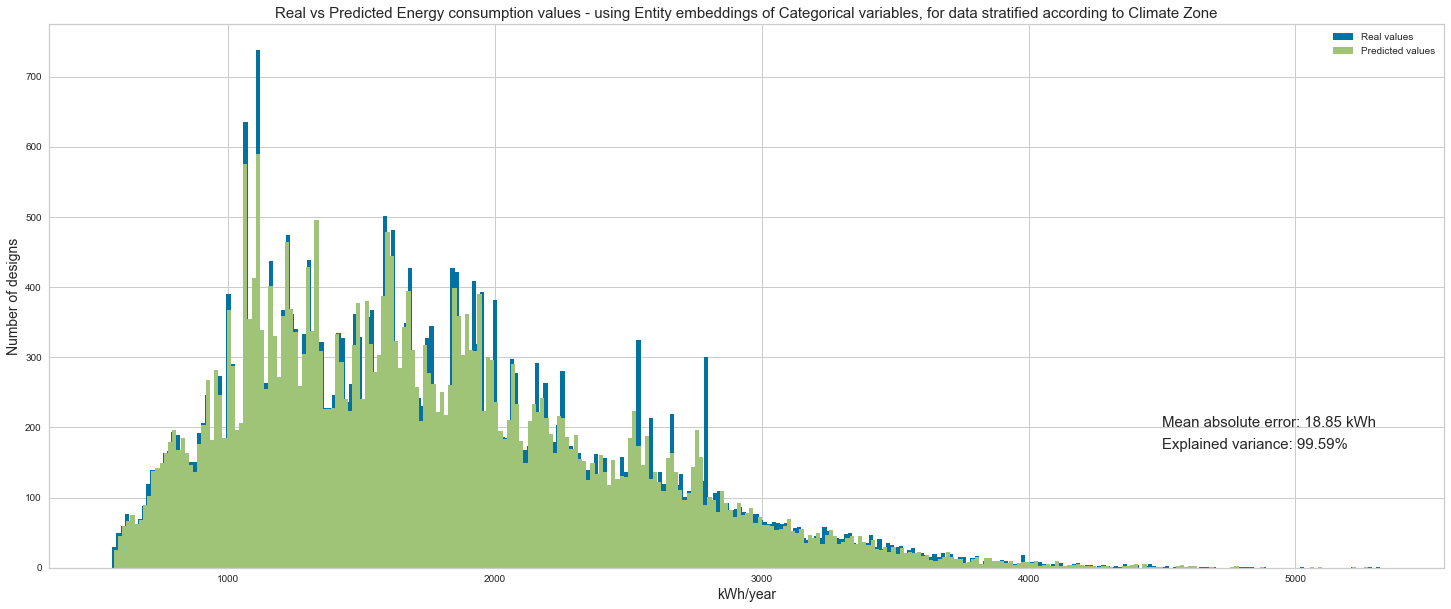

In [215]:
plt.figure(figsize=(25,10))
plt.hist(test_data['Consumption'], bins=300, label='Real values')
plt.hist(pred_test, bins=300, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - using Entity embeddings of Categorical variables, for data stratified according to Climate Zone', fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(test_data['Consumption'], pred_test)), fontsize=15)
plt.text(4500, 170, ("Explained variance:" + "{: .2%}".format(r2_score(test_data['Consumption'], pred_test))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
#plt.savefig("CategoricalEmbeddings_10.jpg", dpi=200)
plt.show()

In [208]:
m.save('reg5')

In [33]:
#m.load('val1')

In [209]:
y = test_data['Consumption'].values
res = test_data['Consumption'].values[:, np.newaxis] - pred_test

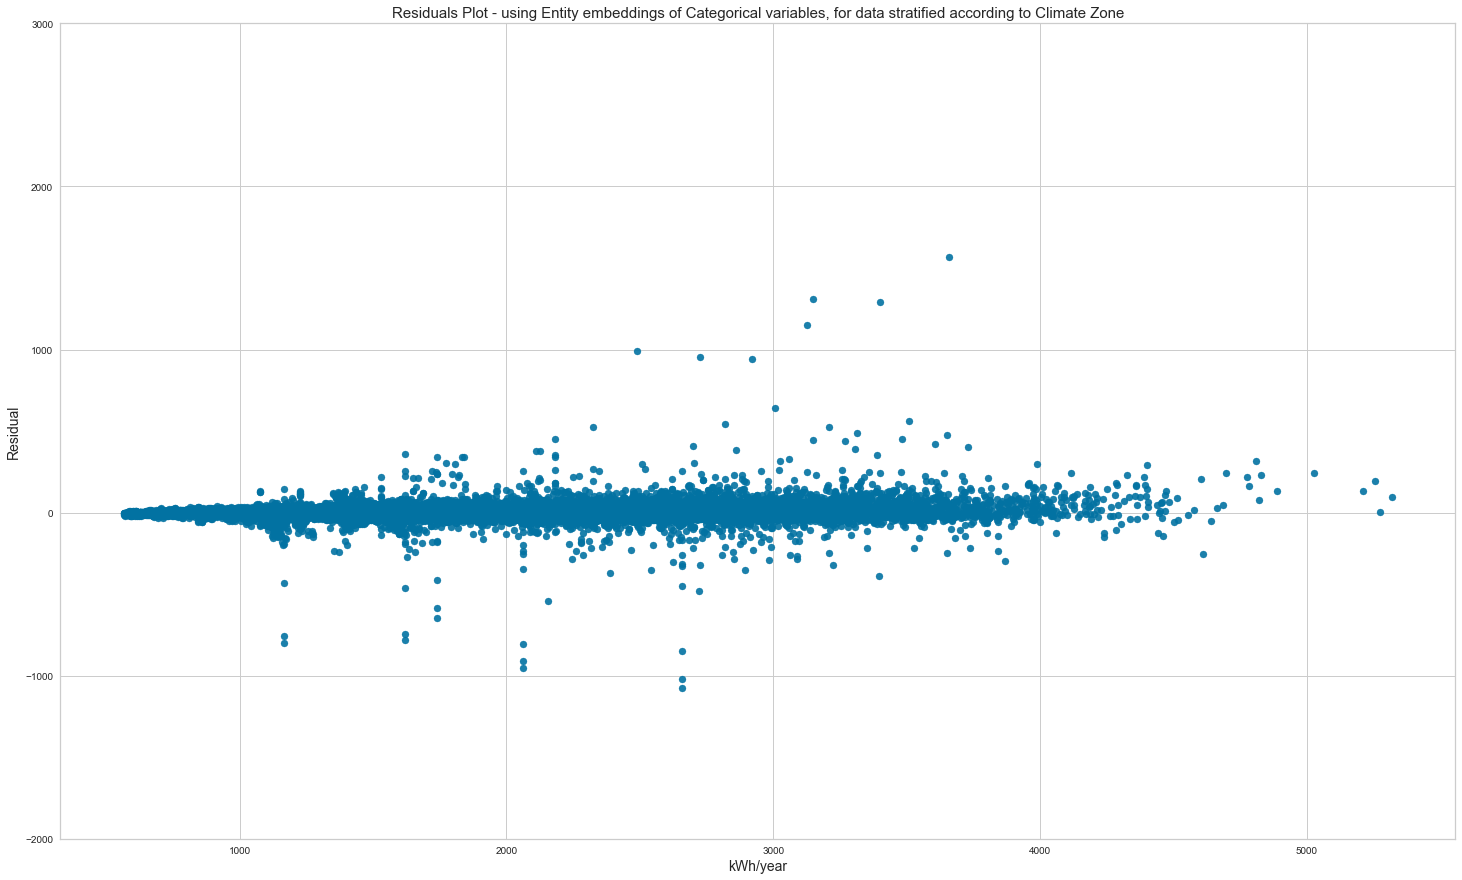

In [210]:
plt.figure(figsize=(25,15))
plt.scatter(y, res, alpha=0.9)
plt.title('Residuals Plot - using Entity embeddings of Categorical variables, for data stratified according to Climate Zone', fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.ylim((-2000, 3000))
plt.savefig("Residuals_10.jpg", dpi=200)
plt.show()

In [211]:
df_check['Res7'] = res

In [216]:
df_check.head()

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Res1,Res2,Res3,Res4,Res5,Res6,Res7
0,1,1,1,1,1,2,2,2,179.701833,44.824513,27.460378,29.107106,14.492238,2.754323,6.315846
1,1,1,1,1,1,2,2,3,247.701436,94.849507,44.261433,30.785481,22.934163,-0.320354,3.230305
3,1,1,1,1,1,2,3,2,156.872580,7.391012,8.381735,4.069357,7.945456,0.488180,-1.296610
4,1,1,1,1,1,2,3,3,274.586239,91.998349,25.470395,17.298031,16.925473,21.730282,23.278988
5,1,1,1,1,1,2,1,1,411.888711,183.652871,89.585244,69.665078,-13.835898,-0.239341,2.699502


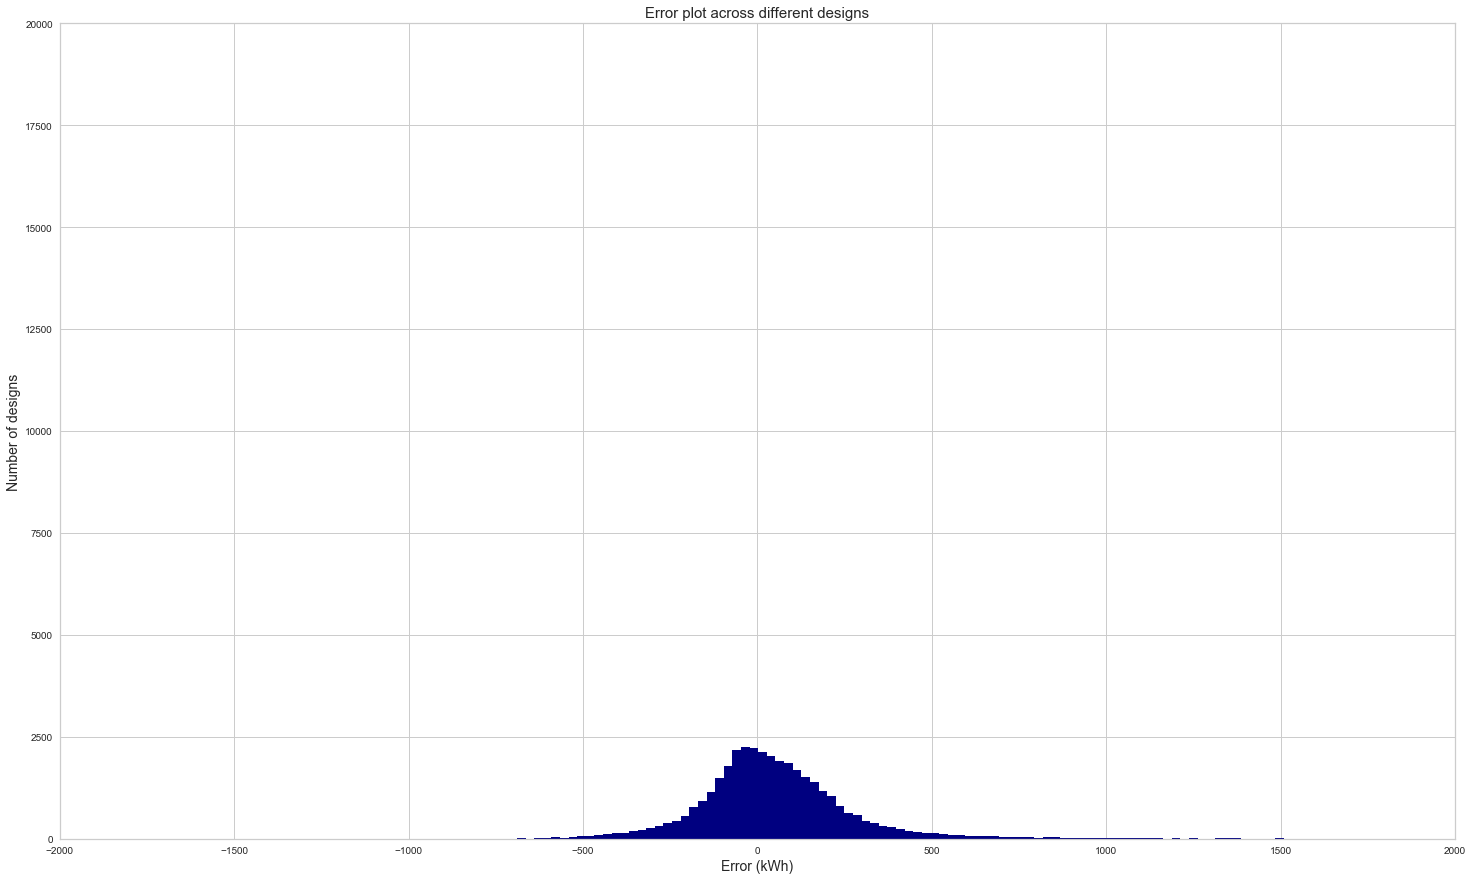

In [241]:
plt.figure(figsize=(25,15))
plt.hist(df_check['Res1'], bins=200, fc=(0,0,0.5))
plt.title('Error plot across different designs', fontsize=15)
plt.xlabel('Error (kWh)', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.ylim((0, 20000))
plt.xlim((-2000, 2000))
plt.savefig("Error_plot_res1.jpg", dpi=200)
plt.show()

In [242]:
df_check.iloc[res.argsort(axis=0)[-20:][::-1].flatten(), :]

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Res1,Res2,Res3,Res4,Res5,Res6,Res7
33883,6,5,7,1,2,1,1,3,968.166804,805.374080,1432.502986,1481.613826,1665.424007,1635.664363,1566.308894
33892,6,5,7,1,2,3,1,3,670.935911,555.605588,1143.608274,1292.016233,1321.225217,1237.980832,1309.017698
33874,6,5,7,1,2,2,1,3,796.814016,669.907034,1237.590628,1315.420706,1364.864187,1357.135183,1289.715139
33856,6,5,7,1,1,1,1,3,559.938682,545.682578,1052.109336,1112.128989,1148.585410,1040.156699,1147.668906
33610,6,5,5,2,1,1,2,3,1055.298923,1229.488254,1145.746677,977.583591,984.409030,967.626926,989.929660
33865,6,5,7,1,1,3,1,3,359.144642,329.501331,785.195789,909.653065,841.217151,667.361439,952.733509
33847,6,5,7,1,1,2,1,3,428.155070,403.579142,843.280802,908.642863,837.121867,749.486613,940.048869
33622,6,5,5,2,1,3,1,3,1077.271650,1111.648969,1040.983076,562.994672,641.135541,684.346967,640.159467
33766,6,5,6,2,1,2,1,3,1477.788342,1416.302380,1257.346570,785.864148,641.440564,583.217908,561.048962
28338,5,5,7,2,3,3,1,3,776.025746,541.973866,504.684315,437.307362,569.909169,284.012685,543.852284


In [246]:
df_check[(df_check['ClimateZone'] == 6) & (df_check['Orientation'] == 5) & (df_check['WWR'] == 7) 
         & (df_check['GlazingType'] == 1) & (df_check['HVAC'] == 1) & (df_check['HeatRecovery'] == 3)]

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Res1,Res2,Res3,Res4,Res5,Res6,Res7
33847,6,5,7,1,1,2,1,3,428.155070,403.579142,843.280802,908.642863,837.121867,749.486613,940.048869
33856,6,5,7,1,1,1,1,3,559.938682,545.682578,1052.109336,1112.128989,1148.585410,1040.156699,1147.668906
33865,6,5,7,1,1,3,1,3,359.144642,329.501331,785.195789,909.653065,841.217151,667.361439,952.733509
33874,6,5,7,1,2,2,1,3,796.814016,669.907034,1237.590628,1315.420706,1364.864187,1357.135183,1289.715139
33883,6,5,7,1,2,1,1,3,968.166804,805.374080,1432.502986,1481.613826,1665.424007,1635.664363,1566.308894
33892,6,5,7,1,2,3,1,3,670.935911,555.605588,1143.608274,1292.016233,1321.225217,1237.980832,1309.017698
33901,6,5,7,1,3,2,1,3,-1637.730078,-1761.288671,-1051.148779,-353.475073,-235.042822,35.379053,-83.449072


In [247]:
train_data[(train_data['ClimateZone'] == 6) & (train_data['Orientation'] == 'West') & (train_data['WWR'] == 70) 
         & (train_data['GlazingType'] == 'TP') & (train_data['HVAC'] == 7) & (train_data['OverhangLength'] == 0.5)]

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Consumption
33765,6,West,70,TP,0.2,0.5,7,1,3511.206959
